<a href="https://colab.research.google.com/github/nullvoid-ky/introduction-to-machine-learning-and-deep-learning/blob/main/bankruptcy_feature_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bankruptcy Feature Selection: 5-Method Importance Playbook

This notebook computes feature importance **using five complementary methods** to help you pick 5–7 attributes for classification:

1. Random Forest (built-in Gini/MDI)
2. Gradient Boosting (built-in importance)
3. Permutation Feature Importance (model-agnostic)
4. SHAP (TreeExplainer over a tree model)
5. Logistic Regression Coefficients (after scaling)

**Dataset**: `utkarshx27/american-companies-bankruptcy-prediction-dataset` via `kagglehub` (as requested).

Outputs:
- Per-method importance tables
- A combined ranking table (average rank & consensus)
- Simple matplotlib bar charts

> Tip: After you review the final combined ranking, pick your **Top 5–7 features** to train your classification model pipeline.

In [1]:
# ===== Setup & Installs (Kaggle usually has most of these; safe to re-run) =====
!pip -q install kagglehub shap lightgbm xgboost

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.inspection import permutation_importance

import shap
import warnings
warnings.filterwarnings('ignore')


## Load Dataset via `kagglehub`
The code below follows your given pattern. Update `file_path` to the CSV within the dataset if needed.

**Expected columns** (as provided):
- `company_name` (drop)  
- `status_label` (target)  
- `year` (1999–2018)  
- `X1 … X18` with meanings per your mapping


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("utkarshx27/american-companies-bankruptcy-prediction-dataset")

print("Path to dataset files:", path)

100%|██████████| 4.47M/4.47M [00:00<00:00, 6.29MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/utkarshx27/american-companies-bankruptcy-prediction-dataset/versions/3


In [5]:
from kagglehub import KaggleDatasetAdapter, load_dataset

# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# Set the CSV file path **inside** the dataset (adjust if needed)
# Explore the dataset directory printed below to confirm the file name.
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
file_path = "/root/.cache/kagglehub/datasets/utkarshx27/american-companies-bankruptcy-prediction-dataset/versions/3/american_bankruptcy.csv"

df = pd.read_csv(file_path)

print("Loaded shape:", df.shape)
print("Columns:\n", list(df.columns))
df.head()

Loaded shape: (78682, 21)
Columns:
 ['company_name', 'status_label', 'year', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18']


,company_name,status_label,year,X1,X2,X3,X4,X5,X6,X7,...,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18
0,C_1,alive,1999,511.267,833.107,18.373,89.031,336.018,35.163,128.348,...,1024.333,740.998,180.447,70.658,191.226,163.816,201.026,1024.333,401.483,935.302
1,C_1,alive,2000,485.856,713.811,18.577,64.367,320.590,18.531,115.187,...,874.255,701.854,179.987,45.790,160.444,125.392,204.065,874.255,361.642,809.888
2,C_1,alive,2001,436.656,526.477,22.496,27.207,286.588,-58.939,77.528,...,638.721,710.199,217.699,4.711,112.244,150.464,139.603,638.721,399.964,611.514
3,C_1,alive,2002,396.412,496.747,27.172,30.745,259.954,-12.410,66.322,...,606.337,686.621,164.658,3.573,109.590,203.575,124.106,606.337,391.633,575.592
4,C_1,alive,2003,432.204,523.302,26.680,47.491,247.245,3.504,104.661,...,651.958,709.292,248.666,20.811,128.656,131.261,131.884,651.958,407.608,604.467


## Basic Preprocessing
- Drop `company_name` (ID-like)
- Keep `year` as numeric (or one-hot encode later if needed)
- Define feature list (exclude `status_label`)
- Impute missing values (median)
- Split into train/test (stratified)


In [7]:
# Drop obvious non-feature column(s)
df_proc = df.copy()
if 'company_name' in df_proc.columns:
    df_proc = df_proc.drop(columns=['company_name'])

target_col = 'status_label'
assert target_col in df_proc.columns, "status_label (target) not found!"

# Identify feature columns (all except target)
feature_cols = [c for c in df_proc.columns if c != target_col]

# Train/Test Split
X = df_proc[feature_cols]
y = df_proc[target_col]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Numeric pipeline: impute median (you can add scaler per-model later)
numeric_features = feature_cols
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
])

preprocess = ColumnTransformer(
    transformers=[("num", numeric_transformer, numeric_features)],
    remainder='drop'
)

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)

Train shape: (59011, 19)  Test shape: (19671, 19)


## 1) Random Forest Importance

In [9]:
rf_pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("rf", RandomForestClassifier(
        n_estimators=4,
        max_depth=None,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1,
    ))
])
rf_pipe.fit(X_train, y_train)
rf = rf_pipe.named_steps['rf']

# Extract fitted features order from ColumnTransformer
feat_names = numeric_features
rf_importance = pd.Series(rf.feature_importances_, index=feat_names).sort_values(ascending=False)
print(rf_importance.head(10))
rf_importance_df = rf_importance.reset_index()
rf_importance_df.columns = ['feature', 'rf_importance']
rf_importance_df.head()

year    0.073888
X15     0.071160
X8      0.067815
X6      0.061435
X13     0.058389
X11     0.055379
X1      0.054995
X12     0.054860
X7      0.052408
X17     0.051968
dtype: float64


,feature,rf_importance
0,year,0.073888
1,X15,0.071160
2,X8,0.067815
3,X6,0.061435
4,X13,0.058389


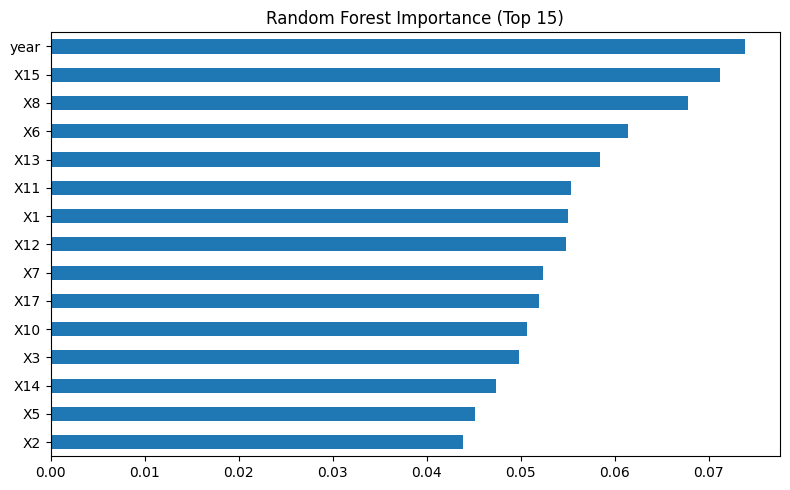

In [10]:
# Plot RF importances
plt.figure(figsize=(8,5))
rf_importance.head(15).iloc[::-1].plot(kind='barh')
plt.title('Random Forest Importance (Top 15)')
plt.tight_layout()
plt.show()

## 2) Gradient Boosting Importance (sklearn GBDT)
*(You can switch to XGBoost/LightGBM if preferred — both also expose built-in importance like `gain`.)*

In [11]:
gb_pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("gb", GradientBoostingClassifier(random_state=42))
])
gb_pipe.fit(X_train, y_train)
gb = gb_pipe.named_steps['gb']
gb_importance = pd.Series(gb.feature_importances_, index=feat_names).sort_values(ascending=False)
print(gb_importance.head(10))
gb_importance_df = gb_importance.reset_index(); gb_importance_df.columns = ['feature','gb_importance']
gb_importance_df.head()

X8      0.147056
year    0.142118
X6      0.122220
X11     0.084288
X3      0.071333
X17     0.052114
X13     0.051508
X5      0.048150
X18     0.043496
X15     0.040045
dtype: float64


,feature,gb_importance
0,X8,0.147056
1,year,0.142118
2,X6,0.122220
3,X11,0.084288
4,X3,0.071333


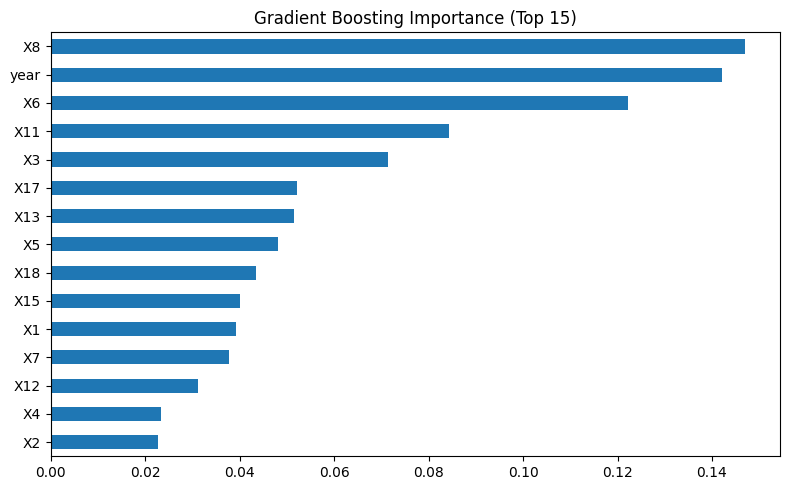

In [12]:
plt.figure(figsize=(8,5))
gb_importance.head(15).iloc[::-1].plot(kind='barh')
plt.title('Gradient Boosting Importance (Top 15)')
plt.tight_layout()
plt.show()

## 3) Permutation Feature Importance (model-agnostic on RF model)
Runs on the **validation** set to estimate performance drop when shuffling each feature.

In [13]:
rf_pipe_score = rf_pipe.score(X_test, y_test)
perm = permutation_importance(rf_pipe, X_test, y_test, n_repeats=4, random_state=42, n_jobs=-1)
perm_scores = pd.Series(perm.importances_mean, index=feat_names).sort_values(ascending=False)
print("Base RF score:", rf_pipe_score)
print(perm_scores.head(10))
perm_df = perm_scores.reset_index(); perm_df.columns = ['feature','perm_importance']
perm_df.head()

Base RF score: 0.9355396268618779
X8     0.002288
X11    0.002097
X17    0.001995
X7     0.001995
X14    0.001830
X15    0.001754
X2     0.001690
X3     0.001652
X13    0.001551
X1     0.001436
dtype: float64


,feature,perm_importance
0,X8,0.002288
1,X11,0.002097
2,X17,0.001995
3,X7,0.001995
4,X14,0.001830


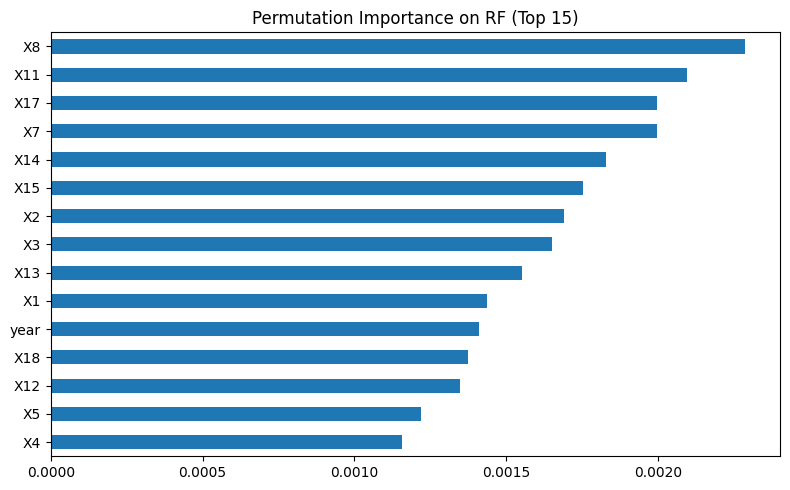

In [14]:
plt.figure(figsize=(8,5))
perm_scores.head(15).iloc[::-1].plot(kind='barh')
plt.title('Permutation Importance on RF (Top 15)')
plt.tight_layout()
plt.show()

## 4) SHAP (TreeExplainer on RF)
We take **mean absolute SHAP value** per feature on the validation set as global importance.

In [22]:
# Build a fresh RF (fitted) object on imputed data to pass raw arrays to SHAP
X_train_imp = preprocess.fit_transform(X_train)
X_test_imp = preprocess.transform(X_test)
rf_shap = RandomForestClassifier(n_estimators=50, class_weight='balanced', random_state=42, n_jobs=-1)
rf_shap.fit(X_train_imp, y_train)

explainer = shap.TreeExplainer(rf_shap)
shap_values = explainer.shap_values(X_test_imp)
if isinstance(shap_values, list):
    # For binary classification, take class 1 contributions
    sv = shap_values[1]
else:
    sv = shap_values
# หลังได้ sv มาแล้ว
sv_abs = np.abs(sv)
if sv_abs.ndim == 3:
    # (n_samples, n_features, n_outputs)
    shap_abs_mean = sv_abs.mean(axis=(0, 2))
elif sv_abs.ndim == 2:
    # (n_samples, n_features)
    shap_abs_mean = sv_abs.mean(axis=0)
else:
    raise ValueError(f"Unexpected SHAP shape: {sv_abs.shape}")

shap_importance = pd.Series(shap_abs_mean, index=feat_names).sort_values(ascending=False)

print(shap_importance.head(10))
shap_df = shap_importance.reset_index(); shap_df.columns = ['feature','shap_importance']
shap_df.head()

year    0.032322
X8      0.031286
X3      0.030738
X6      0.028994
X1      0.028080
X17     0.026898
X13     0.026376
X7      0.025977
X15     0.025666
X10     0.024017
dtype: float64


,feature,shap_importance
0,year,0.032322
1,X8,0.031286
2,X3,0.030738
3,X6,0.028994
4,X1,0.028080


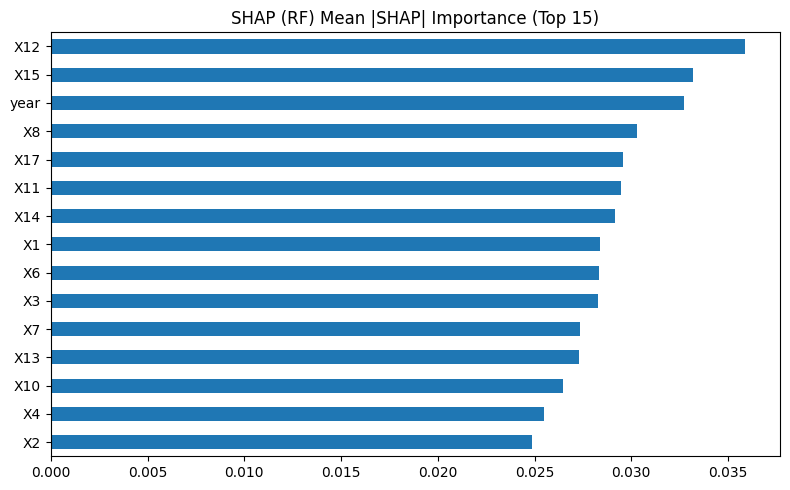

In [21]:
plt.figure(figsize=(8,5))
shap_importance.head(15).iloc[::-1].plot(kind='barh')
plt.title('SHAP (RF) Mean |SHAP| Importance (Top 15)')
plt.tight_layout()
plt.show()

## 5) Logistic Regression Coefficients (after scaling)
We use absolute coefficient magnitude as global importance.
- Pipeline: Impute → Scale → LogisticRegression
- For binary target, take `abs(coef_)`. If OvR, average abs across classes.

In [16]:
logit_pipe = Pipeline(steps=[
    ("prep", ColumnTransformer([
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
        ]), numeric_features),
    ], remainder='drop')),
    ("logit", LogisticRegression(max_iter=2000, class_weight='balanced', solver='lbfgs')),
])
logit_pipe.fit(X_train, y_train)
logit = logit_pipe.named_steps['logit']

coefs = logit.coef_
if coefs.ndim == 1:
    coef_abs = np.abs(coefs)
else:
    coef_abs = np.mean(np.abs(coefs), axis=0)
logit_importance = pd.Series(coef_abs, index=feat_names).sort_values(ascending=False)
print(logit_importance.head(10))
logit_df = logit_importance.reset_index(); logit_df.columns = ['feature','logit_importance']
logit_df.head()

X8      2.679555
X1      1.605701
X17     0.976787
X3      0.831117
X12     0.737278
X14     0.718717
X5      0.518049
year    0.384769
X10     0.357059
X4      0.289506
dtype: float64


,feature,logit_importance
0,X8,2.679555
1,X1,1.605701
2,X17,0.976787
3,X3,0.831117
4,X12,0.737278


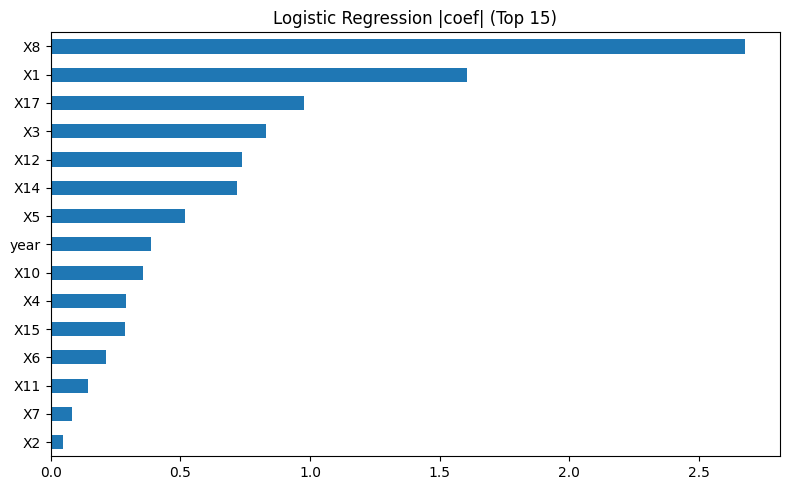

In [17]:
plt.figure(figsize=(8,5))
logit_importance.head(15).iloc[::-1].plot(kind='barh')
plt.title('Logistic Regression |coef| (Top 15)')
plt.tight_layout()
plt.show()

## Combine Rankings
We convert each method’s importances into ranks (1 = most important), then compute **average rank** and **consensus count** (how many methods put the feature in Top-k).

In [27]:
dfs = [rf_importance_df, gb_importance_df,shap_df, perm_df, logit_df]
merged = None
for d in dfs:
    merged = d if merged is None else merged.merge(d, on='feature', how='outer')

# Fill missing with 0 importance (if any)
for c in merged.columns:
    if c != 'feature':
        merged[c] = merged[c].fillna(0.0)

# Create per-method ranks (1=best). Use rank(ascending=False).
rank_cols = []
for c in merged.columns:
    if c != 'feature':
        rname = c + '_rank'
        merged[rname] = merged[c].rank(ascending=False, method='average')
        rank_cols.append(rname)

merged['avg_rank'] = merged[rank_cols].mean(axis=1)
merged_sorted = merged.sort_values('avg_rank', ascending=True)
merged_sorted.head(15)

,feature,rf_importance,gb_importance,shap_importance,perm_importance,logit_importance,rf_importance_rank,gb_importance_rank,shap_importance_rank,perm_importance_rank,logit_importance_rank,avg_rank
16,X8,0.067815,0.147056,0.031286,0.002288,2.679555,3.0,1.0,2.0,1.0,1.0,1.6
18,year,0.073888,0.142118,0.032322,0.001411,0.384769,1.0,2.0,1.0,11.0,8.0,4.6
8,X17,0.051968,0.052114,0.026898,0.001995,0.976787,10.0,6.0,6.0,3.5,3.0,5.7
11,X3,0.049805,0.071333,0.030738,0.001652,0.831117,12.0,5.0,3.0,8.0,4.0,6.4
0,X1,0.054995,0.039254,0.028080,0.001436,1.605701,7.0,11.0,5.0,10.0,2.0,7.0
2,X11,0.055379,0.084288,0.023973,0.002097,0.143085,6.0,4.0,11.0,2.0,13.0,7.2
6,X15,0.071160,0.040045,0.025666,0.001754,0.287402,2.0,10.0,9.0,6.0,11.0,7.6
14,X6,0.061435,0.122220,0.028994,0.001093,0.213372,4.0,3.0,4.0,17.0,12.0,8.0
15,X7,0.052408,0.037675,0.025977,0.001995,0.079842,9.0,12.0,8.0,3.5,14.0,9.3
4,X13,0.058389,0.051508,0.026376,0.001551,0.001967,5.0,7.0,7.0,9.0,19.0,9.4


Top-15 features by average rank:


,feature,avg_rank,rf_importance_rank,gb_importance_rank,shap_importance_rank,perm_importance_rank,logit_importance_rank,avg_rank
16,X8,1.6,3.0,1.0,2.0,1.0,1.0,1.6
18,year,4.6,1.0,2.0,1.0,11.0,8.0,4.6
8,X17,5.7,10.0,6.0,6.0,3.5,3.0,5.7
11,X3,6.4,12.0,5.0,3.0,8.0,4.0,6.4
0,X1,7.0,7.0,11.0,5.0,10.0,2.0,7.0
2,X11,7.2,6.0,4.0,11.0,2.0,13.0,7.2
6,X15,7.6,2.0,10.0,9.0,6.0,11.0,7.6
14,X6,8.0,4.0,3.0,4.0,17.0,12.0,8.0
15,X7,9.3,9.0,12.0,8.0,3.5,14.0,9.3
4,X13,9.4,5.0,7.0,7.0,9.0,19.0,9.4


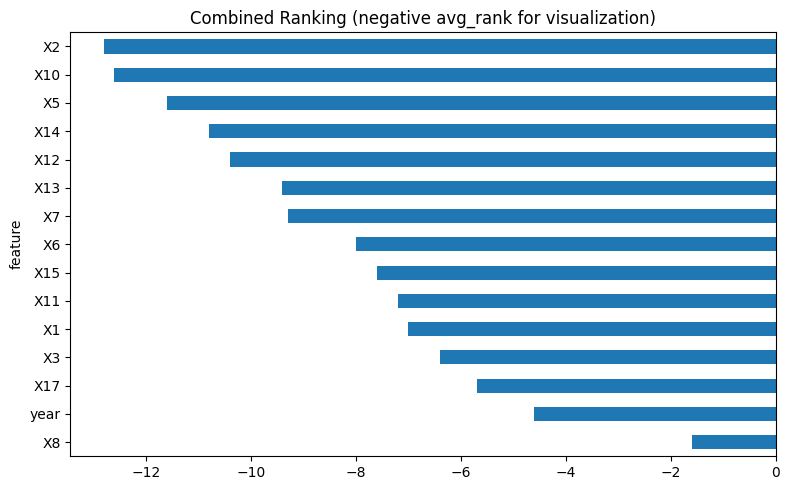

In [28]:
from math import ceil
TOP_K = 15
topk = merged_sorted.head(TOP_K).copy()
print("Top-{} features by average rank:".format(TOP_K))
display(topk[['feature','avg_rank'] + [c for c in merged.columns if c.endswith('_rank')]])

# Plot combined top-k by (negative avg_rank for bar chart convenience)
plt.figure(figsize=(8,5))
to_plot = topk.set_index('feature')['avg_rank'].sort_values(ascending=False)
( -to_plot ).iloc[::-1].plot(kind='barh')
plt.title('Combined Ranking (negative avg_rank for visualization)')
plt.tight_layout()
plt.show()

In [36]:
from itertools import combinations

dfs = [rf_importance_df, gb_importance_df, shap_df, perm_df, logit_df]

all_combos = []
for i in range(1, len(dfs) + 1):
    for combo in combinations(dfs, i):
        all_combos.append(list(combo))
for idx, combo in enumerate(all_combos, 1):
    print(f"\n🔹 Combination {idx}: {len(combo)} DataFrames")
    for df in combo:
        print(df.head(1))  # show first 5 rows




🔹 Combination 1: 1 DataFrames
  feature  rf_importance
0    year       0.073888

🔹 Combination 2: 1 DataFrames
  feature  gb_importance
0      X8       0.147056

🔹 Combination 3: 1 DataFrames
  feature  shap_importance
0    year         0.032322

🔹 Combination 4: 1 DataFrames
  feature  perm_importance
0      X8         0.002288

🔹 Combination 5: 1 DataFrames
  feature  logit_importance
0      X8          2.679555

🔹 Combination 6: 2 DataFrames
  feature  rf_importance
0    year       0.073888
  feature  gb_importance
0      X8       0.147056

🔹 Combination 7: 2 DataFrames
  feature  rf_importance
0    year       0.073888
  feature  shap_importance
0    year         0.032322

🔹 Combination 8: 2 DataFrames
  feature  rf_importance
0    year       0.073888
  feature  perm_importance
0      X8         0.002288

🔹 Combination 9: 2 DataFrames
  feature  rf_importance
0    year       0.073888
  feature  logit_importance
0      X8          2.679555

🔹 Combination 10: 2 DataFrames
  feature  

In [48]:
from functools import reduce
import pandas as pd

iterations_counter = 1
for combo in all_combos:
    print({iterations_counter})
    iterations_counter += 1

    # 1) ตัดคอลัมน์ขยะออกจากแต่ละ DF (เช่น *_rank, avg_rank) ก่อน merge
    cleaned = []
    for d in combo:
        base_cols = [c for c in d.columns
                     if (c == 'feature') or (c != 'feature' and not c.endswith('_rank') and c != 'avg_rank')]
        cleaned.append(d.loc[:, base_cols].copy())

    # 2) merge แบบ outer
    merged = reduce(lambda L, R: L.merge(R, on='feature', how='outer'), cleaned)

    # 3) คอลัมน์ที่จะใช้คำนวณ (ห้ามรวม *_rank / avg_rank)
    value_cols = [c for c in merged.columns
                  if (c != 'feature') and (not c.endswith('_rank')) and (c != 'avg_rank')]

    # 4) เติมค่า NA และบังคับเป็นตัวเลข
    merged[value_cols] = merged[value_cols].apply(pd.to_numeric, errors='coerce').fillna(0.0)

    # 5) คำนวณ rank เฉพาะคอลัมน์ฐานเท่านั้น
    rank_cols = []
    for c in value_cols:
        rname = f"{c}_rank"
        merged[rname] = merged[c].rank(ascending=False, method='average')
        rank_cols.append(rname)

    # 6) avg_rank และจัดเรียง
    merged['avg_rank'] = merged[rank_cols].mean(axis=1)
    merged_sorted = merged.sort_values('avg_rank', ascending=True)

    # 7) แสดงผลให้สวย: โชว์เฉพาะ rank ที่เพิ่งสร้าง (ไม่โชว์ rank ของ rank)
    TOP_K = 8
    to_show = ['feature', 'avg_rank'] + rank_cols
    print(f"Top-{TOP_K} features by average rank:")
    display(merged_sorted.loc[:, to_show].head(TOP_K))


{1}
Top-8 features by average rank:


,feature,avg_rank,rf_importance_rank
0,year,1.0,1.0
1,X15,2.0,2.0
2,X8,3.0,3.0
3,X6,4.0,4.0
4,X13,5.0,5.0
5,X11,6.0,6.0
6,X1,7.0,7.0
7,X12,8.0,8.0


{2}
Top-8 features by average rank:


,feature,avg_rank,gb_importance_rank
0,X8,1.0,1.0
1,year,2.0,2.0
2,X6,3.0,3.0
3,X11,4.0,4.0
4,X3,5.0,5.0
5,X17,6.0,6.0
6,X13,7.0,7.0
7,X5,8.0,8.0


{3}
Top-8 features by average rank:


,feature,avg_rank,shap_importance_rank
0,year,1.0,1.0
1,X8,2.0,2.0
2,X3,3.0,3.0
3,X6,4.0,4.0
4,X1,5.0,5.0
5,X17,6.0,6.0
6,X13,7.0,7.0
7,X7,8.0,8.0


{4}
Top-8 features by average rank:


,feature,avg_rank,perm_importance_rank
0,X8,1.0,1.0
1,X11,2.0,2.0
2,X17,3.5,3.5
3,X7,3.5,3.5
4,X14,5.0,5.0
5,X15,6.0,6.0
6,X2,7.0,7.0
7,X3,8.0,8.0


{5}
Top-8 features by average rank:


,feature,avg_rank,logit_importance_rank
0,X8,1.0,1.0
1,X1,2.0,2.0
2,X17,3.0,3.0
3,X3,4.0,4.0
4,X12,5.0,5.0
5,X14,6.0,6.0
6,X5,7.0,7.0
7,year,8.0,8.0


{6}
Top-8 features by average rank:


,feature,avg_rank,rf_importance_rank,gb_importance_rank
18,year,1.5,1.0,2.0
16,X8,2.0,3.0,1.0
14,X6,3.5,4.0,3.0
2,X11,5.0,6.0,4.0
6,X15,6.0,2.0,10.0
4,X13,6.0,5.0,7.0
8,X17,8.0,10.0,6.0
11,X3,8.5,12.0,5.0


{7}
Top-8 features by average rank:


,feature,avg_rank,rf_importance_rank,shap_importance_rank
18,year,1.0,1.0,1.0
16,X8,2.5,3.0,2.0
14,X6,4.0,4.0,4.0
6,X15,5.5,2.0,9.0
4,X13,6.0,5.0,7.0
0,X1,6.0,7.0,5.0
11,X3,7.5,12.0,3.0
8,X17,8.0,10.0,6.0


{8}
Top-8 features by average rank:


,feature,avg_rank,rf_importance_rank,perm_importance_rank
16,X8,2.00,3.0,1.0
2,X11,4.00,6.0,2.0
6,X15,4.00,2.0,6.0
18,year,6.00,1.0,11.0
15,X7,6.25,9.0,3.5
8,X17,6.75,10.0,3.5
4,X13,7.00,5.0,9.0
0,X1,8.50,7.0,10.0


{9}
Top-8 features by average rank:


,feature,avg_rank,rf_importance_rank,logit_importance_rank
16,X8,2.0,3.0,1.0
0,X1,4.5,7.0,2.0
18,year,4.5,1.0,8.0
3,X12,6.5,8.0,5.0
6,X15,6.5,2.0,11.0
8,X17,6.5,10.0,3.0
11,X3,8.0,12.0,4.0
14,X6,8.0,4.0,12.0


{10}
Top-8 features by average rank:


,feature,avg_rank,gb_importance_rank,shap_importance_rank
18,year,1.5,2.0,1.0
16,X8,1.5,1.0,2.0
14,X6,3.5,3.0,4.0
11,X3,4.0,5.0,3.0
8,X17,6.0,6.0,6.0
4,X13,7.0,7.0,7.0
2,X11,7.5,4.0,11.0
0,X1,8.0,11.0,5.0


{11}
Top-8 features by average rank:


,feature,avg_rank,gb_importance_rank,perm_importance_rank
16,X8,1.00,1.0,1.0
2,X11,3.00,4.0,2.0
8,X17,4.75,6.0,3.5
11,X3,6.50,5.0,8.0
18,year,6.50,2.0,11.0
15,X7,7.75,12.0,3.5
6,X15,8.00,10.0,6.0
4,X13,8.00,7.0,9.0


{12}
Top-8 features by average rank:


,feature,avg_rank,gb_importance_rank,logit_importance_rank
16,X8,1.0,1.0,1.0
11,X3,4.5,5.0,4.0
8,X17,4.5,6.0,3.0
18,year,5.0,2.0,8.0
0,X1,6.5,11.0,2.0
14,X6,7.5,3.0,12.0
13,X5,7.5,8.0,7.0
2,X11,8.5,4.0,13.0


{13}
Top-8 features by average rank:


,feature,avg_rank,shap_importance_rank,perm_importance_rank
16,X8,1.50,2.0,1.0
8,X17,4.75,6.0,3.5
11,X3,5.50,3.0,8.0
15,X7,5.75,8.0,3.5
18,year,6.00,1.0,11.0
2,X11,6.50,11.0,2.0
6,X15,7.50,9.0,6.0
0,X1,7.50,5.0,10.0


{14}
Top-8 features by average rank:


,feature,avg_rank,shap_importance_rank,logit_importance_rank
16,X8,1.5,2.0,1.0
0,X1,3.5,5.0,2.0
11,X3,3.5,3.0,4.0
8,X17,4.5,6.0,3.0
18,year,4.5,1.0,8.0
14,X6,8.0,4.0,12.0
3,X12,9.0,13.0,5.0
1,X10,9.5,10.0,9.0


{15}
Top-8 features by average rank:


,feature,avg_rank,perm_importance_rank,logit_importance_rank
16,X8,1.00,1.0,1.0
8,X17,3.25,3.5,3.0
5,X14,5.50,5.0,6.0
11,X3,6.00,8.0,4.0
0,X1,6.00,10.0,2.0
2,X11,7.50,2.0,13.0
6,X15,8.50,6.0,11.0
15,X7,8.75,3.5,14.0


{16}
Top-8 features by average rank:


,feature,avg_rank,rf_importance_rank,gb_importance_rank,shap_importance_rank
18,year,1.333333,1.0,2.0,1.0
16,X8,2.000000,3.0,1.0,2.0
14,X6,3.666667,4.0,3.0,4.0
4,X13,6.333333,5.0,7.0,7.0
11,X3,6.666667,12.0,5.0,3.0
2,X11,7.000000,6.0,4.0,11.0
6,X15,7.000000,2.0,10.0,9.0
8,X17,7.333333,10.0,6.0,6.0


{17}
Top-8 features by average rank:


,feature,avg_rank,rf_importance_rank,gb_importance_rank,perm_importance_rank
16,X8,1.666667,3.0,1.0,1.0
2,X11,4.000000,6.0,4.0,2.0
18,year,4.666667,1.0,2.0,11.0
6,X15,6.000000,2.0,10.0,6.0
8,X17,6.500000,10.0,6.0,3.5
4,X13,7.000000,5.0,7.0,9.0
14,X6,8.000000,4.0,3.0,17.0
15,X7,8.166667,9.0,12.0,3.5


{18}
Top-8 features by average rank:


,feature,avg_rank,rf_importance_rank,gb_importance_rank,logit_importance_rank
16,X8,1.666667,3.0,1.0,1.0
18,year,3.666667,1.0,2.0,8.0
14,X6,6.333333,4.0,3.0,12.0
8,X17,6.333333,10.0,6.0,3.0
0,X1,6.666667,7.0,11.0,2.0
11,X3,7.000000,12.0,5.0,4.0
6,X15,7.666667,2.0,10.0,11.0
2,X11,7.666667,6.0,4.0,13.0


{19}
Top-8 features by average rank:


,feature,avg_rank,rf_importance_rank,shap_importance_rank,perm_importance_rank
16,X8,2.000000,3.0,2.0,1.0
18,year,4.333333,1.0,1.0,11.0
6,X15,5.666667,2.0,9.0,6.0
2,X11,6.333333,6.0,11.0,2.0
8,X17,6.500000,10.0,6.0,3.5
15,X7,6.833333,9.0,8.0,3.5
4,X13,7.000000,5.0,7.0,9.0
0,X1,7.333333,7.0,5.0,10.0


{20}
Top-8 features by average rank:


,feature,avg_rank,rf_importance_rank,shap_importance_rank,logit_importance_rank
16,X8,2.000000,3.0,2.0,1.0
18,year,3.333333,1.0,1.0,8.0
0,X1,4.666667,7.0,5.0,2.0
8,X17,6.333333,10.0,6.0,3.0
11,X3,6.333333,12.0,3.0,4.0
14,X6,6.666667,4.0,4.0,12.0
6,X15,7.333333,2.0,9.0,11.0
3,X12,8.666667,8.0,13.0,5.0


{21}
Top-8 features by average rank:


,feature,avg_rank,rf_importance_rank,perm_importance_rank,logit_importance_rank
16,X8,1.666667,3.0,1.0,1.0
8,X17,5.500000,10.0,3.5,3.0
6,X15,6.333333,2.0,6.0,11.0
0,X1,6.333333,7.0,10.0,2.0
18,year,6.666667,1.0,11.0,8.0
2,X11,7.000000,6.0,2.0,13.0
11,X3,8.000000,12.0,8.0,4.0
5,X14,8.000000,13.0,5.0,6.0


{22}
Top-8 features by average rank:


,feature,avg_rank,gb_importance_rank,shap_importance_rank,perm_importance_rank
16,X8,1.333333,1.0,2.0,1.0
18,year,4.666667,2.0,1.0,11.0
8,X17,5.166667,6.0,6.0,3.5
11,X3,5.333333,5.0,3.0,8.0
2,X11,5.666667,4.0,11.0,2.0
4,X13,7.666667,7.0,7.0,9.0
15,X7,7.833333,12.0,8.0,3.5
14,X6,8.000000,3.0,4.0,17.0


{23}
Top-8 features by average rank:


,feature,avg_rank,gb_importance_rank,shap_importance_rank,logit_importance_rank
16,X8,1.333333,1.0,2.0,1.0
18,year,3.666667,2.0,1.0,8.0
11,X3,4.000000,5.0,3.0,4.0
8,X17,5.000000,6.0,6.0,3.0
0,X1,6.000000,11.0,5.0,2.0
14,X6,6.333333,3.0,4.0,12.0
2,X11,9.333333,4.0,11.0,13.0
13,X5,10.000000,8.0,15.0,7.0


{24}
Top-8 features by average rank:


,feature,avg_rank,gb_importance_rank,perm_importance_rank,logit_importance_rank
16,X8,1.000000,1.0,1.0,1.0
8,X17,4.166667,6.0,3.5,3.0
11,X3,5.666667,5.0,8.0,4.0
2,X11,6.333333,4.0,2.0,13.0
18,year,7.000000,2.0,11.0,8.0
0,X1,7.666667,11.0,10.0,2.0
6,X15,9.000000,10.0,6.0,11.0
5,X14,9.000000,16.0,5.0,6.0


{25}
Top-8 features by average rank:


,feature,avg_rank,shap_importance_rank,perm_importance_rank,logit_importance_rank
16,X8,1.333333,2.0,1.0,1.0
8,X17,4.166667,6.0,3.5,3.0
11,X3,5.000000,3.0,8.0,4.0
0,X1,5.666667,5.0,10.0,2.0
18,year,6.666667,1.0,11.0,8.0
5,X14,8.333333,14.0,5.0,6.0
15,X7,8.500000,8.0,3.5,14.0
6,X15,8.666667,9.0,6.0,11.0


{26}
Top-8 features by average rank:


,feature,avg_rank,rf_importance_rank,gb_importance_rank,shap_importance_rank,perm_importance_rank
16,X8,1.750,3.0,1.0,2.0,1.0
18,year,3.750,1.0,2.0,1.0,11.0
2,X11,5.750,6.0,4.0,11.0,2.0
8,X17,6.375,10.0,6.0,6.0,3.5
6,X15,6.750,2.0,10.0,9.0,6.0
14,X6,7.000,4.0,3.0,4.0,17.0
11,X3,7.000,12.0,5.0,3.0,8.0
4,X13,7.000,5.0,7.0,7.0,9.0


{27}
Top-8 features by average rank:


,feature,avg_rank,rf_importance_rank,gb_importance_rank,shap_importance_rank,logit_importance_rank
16,X8,1.75,3.0,1.0,2.0,1.0
18,year,3.00,1.0,2.0,1.0,8.0
14,X6,5.75,4.0,3.0,4.0,12.0
11,X3,6.00,12.0,5.0,3.0,4.0
0,X1,6.25,7.0,11.0,5.0,2.0
8,X17,6.25,10.0,6.0,6.0,3.0
6,X15,8.00,2.0,10.0,9.0,11.0
2,X11,8.50,6.0,4.0,11.0,13.0


{28}
Top-8 features by average rank:


,feature,avg_rank,rf_importance_rank,gb_importance_rank,perm_importance_rank,logit_importance_rank
16,X8,1.500,3.0,1.0,1.0,1.0
18,year,5.500,1.0,2.0,11.0,8.0
8,X17,5.625,10.0,6.0,3.5,3.0
2,X11,6.250,6.0,4.0,2.0,13.0
11,X3,7.250,12.0,5.0,8.0,4.0
6,X15,7.250,2.0,10.0,6.0,11.0
0,X1,7.500,7.0,11.0,10.0,2.0
14,X6,9.000,4.0,3.0,17.0,12.0


{29}
Top-8 features by average rank:


,feature,avg_rank,rf_importance_rank,shap_importance_rank,perm_importance_rank,logit_importance_rank
16,X8,1.750,3.0,2.0,1.0,1.0
18,year,5.250,1.0,1.0,11.0,8.0
8,X17,5.625,10.0,6.0,3.5,3.0
0,X1,6.000,7.0,5.0,10.0,2.0
11,X3,6.750,12.0,3.0,8.0,4.0
6,X15,7.000,2.0,9.0,6.0,11.0
2,X11,8.000,6.0,11.0,2.0,13.0
15,X7,8.625,9.0,8.0,3.5,14.0


{30}
Top-8 features by average rank:


,feature,avg_rank,gb_importance_rank,shap_importance_rank,perm_importance_rank,logit_importance_rank
16,X8,1.250,1.0,2.0,1.0,1.0
8,X17,4.625,6.0,6.0,3.5,3.0
11,X3,5.000,5.0,3.0,8.0,4.0
18,year,5.500,2.0,1.0,11.0,8.0
0,X1,7.000,11.0,5.0,10.0,2.0
2,X11,7.500,4.0,11.0,2.0,13.0
6,X15,9.000,10.0,9.0,6.0,11.0
14,X6,9.000,3.0,4.0,17.0,12.0


{31}
Top-8 features by average rank:


,feature,avg_rank,rf_importance_rank,gb_importance_rank,shap_importance_rank,perm_importance_rank,logit_importance_rank
16,X8,1.6,3.0,1.0,2.0,1.0,1.0
18,year,4.6,1.0,2.0,1.0,11.0,8.0
8,X17,5.7,10.0,6.0,6.0,3.5,3.0
11,X3,6.4,12.0,5.0,3.0,8.0,4.0
0,X1,7.0,7.0,11.0,5.0,10.0,2.0
2,X11,7.2,6.0,4.0,11.0,2.0,13.0
6,X15,7.6,2.0,10.0,9.0,6.0,11.0
14,X6,8.0,4.0,3.0,4.0,17.0,12.0


In [49]:
from functools import reduce
import pandas as pd
import numpy as np

iterations_counter = 1
combo_summaries = []  # เก็บ (feature, avg_rank, combo_id) ของทุกตาราง

for combo in all_combos:
    print({iterations_counter})
    combo_id = iterations_counter
    iterations_counter += 1

    # 1) ล้างคอลัมน์ที่เป็น rank/avg_rank ออกจาก DF แต่ละตัวก่อน merge
    cleaned = []
    for d in combo:
        base_cols = [c for c in d.columns
                     if (c == 'feature') or (c != 'feature' and not c.endswith('_rank') and c != 'avg_rank')]
        cleaned.append(d.loc[:, base_cols].copy())

    # 2) merge แบบ outer
    merged = reduce(lambda L, R: L.merge(R, on='feature', how='outer'), cleaned)

    # 3) คอลัมน์ฐานที่ใช้คำนวณ (ไม่รวม *_rank / avg_rank)
    value_cols = [c for c in merged.columns
                  if (c != 'feature') and (not c.endswith('_rank')) and (c != 'avg_rank')]

    merged[value_cols] = merged[value_cols].apply(pd.to_numeric, errors='coerce').fillna(0.0)

    # 4) คำนวณ rank ราย method แล้วทำ avg_rank
    rank_cols = []
    for c in value_cols:
        rname = f"{c}_rank"
        merged[rname] = merged[c].rank(ascending=False, method='average')
        rank_cols.append(rname)

    merged['avg_rank'] = merged[rank_cols].mean(axis=1)
    merged_sorted = merged.sort_values('avg_rank', ascending=True)

    # เก็บสรุปของตารางนี้ (เฉพาะ feature + avg_rank) ลงคลังรวม
    combo_summaries.append(
        merged_sorted.loc[:, ['feature','avg_rank']].assign(combo_id=combo_id)
    )

    # แสดง top-k ของตารางนี้ตามเดิม
    TOP_K = 8
    to_show = ['feature','avg_rank'] + rank_cols
    print(f"Top-{TOP_K} features by average rank:")
    display(merged_sorted.loc[:, to_show].head(TOP_K))

# =========================
#  สรุปข้าม 31 ตาราง
# =========================
all_runs = pd.concat(combo_summaries, ignore_index=True)

# รวมเป็นราย feature -> list ของ avg_rank ทุกตาราง
# แล้วคำนวณ mean/median/mode
def mode_min(s: pd.Series):
    m = s.mode()  # อาจได้หลายค่า
    return m.min() if len(m) else np.nan

stats = (all_runs
         .groupby('feature')['avg_rank']
         .agg(avg_rank_mean='mean',
              avg_rank_median='median',
              avg_rank_mode=mode_min)
         .reset_index())

# บันทึกไฟล์สรุป (เรียงจาก mean น้อยสุด = ดีสุด)
stats_sorted = stats.sort_values('avg_rank_mean', ascending=True)
stats_sorted.to_csv('feature_rank_stats_across_31_combos.csv', index=False)

# หา “มากสุด” และ “น้อยสุด(ดีที่สุด)” ของแต่ละสถิติ
def best_worst(series: pd.Series):
    # น้อยสุด = ดีสุด (rank ดี)
    best_idx = series.idxmin()
    worst_idx = series.idxmax()
    return best_idx, worst_idx

best_mean_idx,  worst_mean_idx  = best_worst(stats['avg_rank_mean'])
best_med_idx,   worst_med_idx   = best_worst(stats['avg_rank_median'])
best_mode_idx,  worst_mode_idx  = best_worst(stats['avg_rank_mode'])

print("\n=== สรุปข้าม 31 ตาราง ===")
print("ไฟล์สรุป: feature_rank_stats_across_31_combos.csv")

print("\n[ค่าเฉลี่ย (mean) ของ avg_rank]")
print("  ดีสุด (น้อยสุด):", stats.loc[best_mean_idx,  'feature'], stats.loc[best_mean_idx,  'avg_rank_mean'])
print("  มากสุด:",           stats.loc[worst_mean_idx, 'feature'], stats.loc[worst_mean_idx, 'avg_rank_mean'])

print("\n[มัธยฐาน (median) ของ avg_rank]")
print("  ดีสุด (น้อยสุด):", stats.loc[best_med_idx,   'feature'], stats.loc[best_med_idx,   'avg_rank_median'])
print("  มากสุด:",           stats.loc[worst_med_idx,  'feature'], stats.loc[worst_med_idx,  'avg_rank_median'])

print("\n[ฐานนิยม (mode) ของ avg_rank]")
print("  ดีสุด (น้อยสุด):", stats.loc[best_mode_idx,  'feature'], stats.loc[best_mode_idx,  'avg_rank_mode'])
print("  มากสุด:",           stats.loc[worst_mode_idx, 'feature'], stats.loc[worst_mode_idx, 'avg_rank_mode'])

# ถ้าอยากดูตารางสรุปบนจอด้วย
display(stats_sorted.head(20))


{1}
Top-8 features by average rank:


,feature,avg_rank,rf_importance_rank
0,year,1.0,1.0
1,X15,2.0,2.0
2,X8,3.0,3.0
3,X6,4.0,4.0
4,X13,5.0,5.0
5,X11,6.0,6.0
6,X1,7.0,7.0
7,X12,8.0,8.0


{2}
Top-8 features by average rank:


,feature,avg_rank,gb_importance_rank
0,X8,1.0,1.0
1,year,2.0,2.0
2,X6,3.0,3.0
3,X11,4.0,4.0
4,X3,5.0,5.0
5,X17,6.0,6.0
6,X13,7.0,7.0
7,X5,8.0,8.0


{3}
Top-8 features by average rank:


,feature,avg_rank,shap_importance_rank
0,year,1.0,1.0
1,X8,2.0,2.0
2,X3,3.0,3.0
3,X6,4.0,4.0
4,X1,5.0,5.0
5,X17,6.0,6.0
6,X13,7.0,7.0
7,X7,8.0,8.0


{4}
Top-8 features by average rank:


,feature,avg_rank,perm_importance_rank
0,X8,1.0,1.0
1,X11,2.0,2.0
2,X17,3.5,3.5
3,X7,3.5,3.5
4,X14,5.0,5.0
5,X15,6.0,6.0
6,X2,7.0,7.0
7,X3,8.0,8.0


{5}
Top-8 features by average rank:


,feature,avg_rank,logit_importance_rank
0,X8,1.0,1.0
1,X1,2.0,2.0
2,X17,3.0,3.0
3,X3,4.0,4.0
4,X12,5.0,5.0
5,X14,6.0,6.0
6,X5,7.0,7.0
7,year,8.0,8.0


{6}
Top-8 features by average rank:


,feature,avg_rank,rf_importance_rank,gb_importance_rank
18,year,1.5,1.0,2.0
16,X8,2.0,3.0,1.0
14,X6,3.5,4.0,3.0
2,X11,5.0,6.0,4.0
6,X15,6.0,2.0,10.0
4,X13,6.0,5.0,7.0
8,X17,8.0,10.0,6.0
11,X3,8.5,12.0,5.0


{7}
Top-8 features by average rank:


,feature,avg_rank,rf_importance_rank,shap_importance_rank
18,year,1.0,1.0,1.0
16,X8,2.5,3.0,2.0
14,X6,4.0,4.0,4.0
6,X15,5.5,2.0,9.0
4,X13,6.0,5.0,7.0
0,X1,6.0,7.0,5.0
11,X3,7.5,12.0,3.0
8,X17,8.0,10.0,6.0


{8}
Top-8 features by average rank:


,feature,avg_rank,rf_importance_rank,perm_importance_rank
16,X8,2.00,3.0,1.0
2,X11,4.00,6.0,2.0
6,X15,4.00,2.0,6.0
18,year,6.00,1.0,11.0
15,X7,6.25,9.0,3.5
8,X17,6.75,10.0,3.5
4,X13,7.00,5.0,9.0
0,X1,8.50,7.0,10.0


{9}
Top-8 features by average rank:


,feature,avg_rank,rf_importance_rank,logit_importance_rank
16,X8,2.0,3.0,1.0
0,X1,4.5,7.0,2.0
18,year,4.5,1.0,8.0
3,X12,6.5,8.0,5.0
6,X15,6.5,2.0,11.0
8,X17,6.5,10.0,3.0
11,X3,8.0,12.0,4.0
14,X6,8.0,4.0,12.0


{10}
Top-8 features by average rank:


,feature,avg_rank,gb_importance_rank,shap_importance_rank
18,year,1.5,2.0,1.0
16,X8,1.5,1.0,2.0
14,X6,3.5,3.0,4.0
11,X3,4.0,5.0,3.0
8,X17,6.0,6.0,6.0
4,X13,7.0,7.0,7.0
2,X11,7.5,4.0,11.0
0,X1,8.0,11.0,5.0


{11}
Top-8 features by average rank:


,feature,avg_rank,gb_importance_rank,perm_importance_rank
16,X8,1.00,1.0,1.0
2,X11,3.00,4.0,2.0
8,X17,4.75,6.0,3.5
11,X3,6.50,5.0,8.0
18,year,6.50,2.0,11.0
15,X7,7.75,12.0,3.5
6,X15,8.00,10.0,6.0
4,X13,8.00,7.0,9.0


{12}
Top-8 features by average rank:


,feature,avg_rank,gb_importance_rank,logit_importance_rank
16,X8,1.0,1.0,1.0
11,X3,4.5,5.0,4.0
8,X17,4.5,6.0,3.0
18,year,5.0,2.0,8.0
0,X1,6.5,11.0,2.0
14,X6,7.5,3.0,12.0
13,X5,7.5,8.0,7.0
2,X11,8.5,4.0,13.0


{13}
Top-8 features by average rank:


,feature,avg_rank,shap_importance_rank,perm_importance_rank
16,X8,1.50,2.0,1.0
8,X17,4.75,6.0,3.5
11,X3,5.50,3.0,8.0
15,X7,5.75,8.0,3.5
18,year,6.00,1.0,11.0
2,X11,6.50,11.0,2.0
6,X15,7.50,9.0,6.0
0,X1,7.50,5.0,10.0


{14}
Top-8 features by average rank:


,feature,avg_rank,shap_importance_rank,logit_importance_rank
16,X8,1.5,2.0,1.0
0,X1,3.5,5.0,2.0
11,X3,3.5,3.0,4.0
8,X17,4.5,6.0,3.0
18,year,4.5,1.0,8.0
14,X6,8.0,4.0,12.0
3,X12,9.0,13.0,5.0
1,X10,9.5,10.0,9.0


{15}
Top-8 features by average rank:


,feature,avg_rank,perm_importance_rank,logit_importance_rank
16,X8,1.00,1.0,1.0
8,X17,3.25,3.5,3.0
5,X14,5.50,5.0,6.0
11,X3,6.00,8.0,4.0
0,X1,6.00,10.0,2.0
2,X11,7.50,2.0,13.0
6,X15,8.50,6.0,11.0
15,X7,8.75,3.5,14.0


{16}
Top-8 features by average rank:


,feature,avg_rank,rf_importance_rank,gb_importance_rank,shap_importance_rank
18,year,1.333333,1.0,2.0,1.0
16,X8,2.000000,3.0,1.0,2.0
14,X6,3.666667,4.0,3.0,4.0
4,X13,6.333333,5.0,7.0,7.0
11,X3,6.666667,12.0,5.0,3.0
2,X11,7.000000,6.0,4.0,11.0
6,X15,7.000000,2.0,10.0,9.0
8,X17,7.333333,10.0,6.0,6.0


{17}
Top-8 features by average rank:


,feature,avg_rank,rf_importance_rank,gb_importance_rank,perm_importance_rank
16,X8,1.666667,3.0,1.0,1.0
2,X11,4.000000,6.0,4.0,2.0
18,year,4.666667,1.0,2.0,11.0
6,X15,6.000000,2.0,10.0,6.0
8,X17,6.500000,10.0,6.0,3.5
4,X13,7.000000,5.0,7.0,9.0
14,X6,8.000000,4.0,3.0,17.0
15,X7,8.166667,9.0,12.0,3.5


{18}
Top-8 features by average rank:


,feature,avg_rank,rf_importance_rank,gb_importance_rank,logit_importance_rank
16,X8,1.666667,3.0,1.0,1.0
18,year,3.666667,1.0,2.0,8.0
14,X6,6.333333,4.0,3.0,12.0
8,X17,6.333333,10.0,6.0,3.0
0,X1,6.666667,7.0,11.0,2.0
11,X3,7.000000,12.0,5.0,4.0
6,X15,7.666667,2.0,10.0,11.0
2,X11,7.666667,6.0,4.0,13.0


{19}
Top-8 features by average rank:


,feature,avg_rank,rf_importance_rank,shap_importance_rank,perm_importance_rank
16,X8,2.000000,3.0,2.0,1.0
18,year,4.333333,1.0,1.0,11.0
6,X15,5.666667,2.0,9.0,6.0
2,X11,6.333333,6.0,11.0,2.0
8,X17,6.500000,10.0,6.0,3.5
15,X7,6.833333,9.0,8.0,3.5
4,X13,7.000000,5.0,7.0,9.0
0,X1,7.333333,7.0,5.0,10.0


{20}
Top-8 features by average rank:


,feature,avg_rank,rf_importance_rank,shap_importance_rank,logit_importance_rank
16,X8,2.000000,3.0,2.0,1.0
18,year,3.333333,1.0,1.0,8.0
0,X1,4.666667,7.0,5.0,2.0
8,X17,6.333333,10.0,6.0,3.0
11,X3,6.333333,12.0,3.0,4.0
14,X6,6.666667,4.0,4.0,12.0
6,X15,7.333333,2.0,9.0,11.0
3,X12,8.666667,8.0,13.0,5.0


{21}
Top-8 features by average rank:


,feature,avg_rank,rf_importance_rank,perm_importance_rank,logit_importance_rank
16,X8,1.666667,3.0,1.0,1.0
8,X17,5.500000,10.0,3.5,3.0
6,X15,6.333333,2.0,6.0,11.0
0,X1,6.333333,7.0,10.0,2.0
18,year,6.666667,1.0,11.0,8.0
2,X11,7.000000,6.0,2.0,13.0
11,X3,8.000000,12.0,8.0,4.0
5,X14,8.000000,13.0,5.0,6.0


{22}
Top-8 features by average rank:


,feature,avg_rank,gb_importance_rank,shap_importance_rank,perm_importance_rank
16,X8,1.333333,1.0,2.0,1.0
18,year,4.666667,2.0,1.0,11.0
8,X17,5.166667,6.0,6.0,3.5
11,X3,5.333333,5.0,3.0,8.0
2,X11,5.666667,4.0,11.0,2.0
4,X13,7.666667,7.0,7.0,9.0
15,X7,7.833333,12.0,8.0,3.5
14,X6,8.000000,3.0,4.0,17.0


{23}
Top-8 features by average rank:


,feature,avg_rank,gb_importance_rank,shap_importance_rank,logit_importance_rank
16,X8,1.333333,1.0,2.0,1.0
18,year,3.666667,2.0,1.0,8.0
11,X3,4.000000,5.0,3.0,4.0
8,X17,5.000000,6.0,6.0,3.0
0,X1,6.000000,11.0,5.0,2.0
14,X6,6.333333,3.0,4.0,12.0
2,X11,9.333333,4.0,11.0,13.0
13,X5,10.000000,8.0,15.0,7.0


{24}
Top-8 features by average rank:


,feature,avg_rank,gb_importance_rank,perm_importance_rank,logit_importance_rank
16,X8,1.000000,1.0,1.0,1.0
8,X17,4.166667,6.0,3.5,3.0
11,X3,5.666667,5.0,8.0,4.0
2,X11,6.333333,4.0,2.0,13.0
18,year,7.000000,2.0,11.0,8.0
0,X1,7.666667,11.0,10.0,2.0
6,X15,9.000000,10.0,6.0,11.0
5,X14,9.000000,16.0,5.0,6.0


{25}
Top-8 features by average rank:


,feature,avg_rank,shap_importance_rank,perm_importance_rank,logit_importance_rank
16,X8,1.333333,2.0,1.0,1.0
8,X17,4.166667,6.0,3.5,3.0
11,X3,5.000000,3.0,8.0,4.0
0,X1,5.666667,5.0,10.0,2.0
18,year,6.666667,1.0,11.0,8.0
5,X14,8.333333,14.0,5.0,6.0
15,X7,8.500000,8.0,3.5,14.0
6,X15,8.666667,9.0,6.0,11.0


{26}
Top-8 features by average rank:


,feature,avg_rank,rf_importance_rank,gb_importance_rank,shap_importance_rank,perm_importance_rank
16,X8,1.750,3.0,1.0,2.0,1.0
18,year,3.750,1.0,2.0,1.0,11.0
2,X11,5.750,6.0,4.0,11.0,2.0
8,X17,6.375,10.0,6.0,6.0,3.5
6,X15,6.750,2.0,10.0,9.0,6.0
14,X6,7.000,4.0,3.0,4.0,17.0
11,X3,7.000,12.0,5.0,3.0,8.0
4,X13,7.000,5.0,7.0,7.0,9.0


{27}
Top-8 features by average rank:


,feature,avg_rank,rf_importance_rank,gb_importance_rank,shap_importance_rank,logit_importance_rank
16,X8,1.75,3.0,1.0,2.0,1.0
18,year,3.00,1.0,2.0,1.0,8.0
14,X6,5.75,4.0,3.0,4.0,12.0
11,X3,6.00,12.0,5.0,3.0,4.0
0,X1,6.25,7.0,11.0,5.0,2.0
8,X17,6.25,10.0,6.0,6.0,3.0
6,X15,8.00,2.0,10.0,9.0,11.0
2,X11,8.50,6.0,4.0,11.0,13.0


{28}
Top-8 features by average rank:


,feature,avg_rank,rf_importance_rank,gb_importance_rank,perm_importance_rank,logit_importance_rank
16,X8,1.500,3.0,1.0,1.0,1.0
18,year,5.500,1.0,2.0,11.0,8.0
8,X17,5.625,10.0,6.0,3.5,3.0
2,X11,6.250,6.0,4.0,2.0,13.0
11,X3,7.250,12.0,5.0,8.0,4.0
6,X15,7.250,2.0,10.0,6.0,11.0
0,X1,7.500,7.0,11.0,10.0,2.0
14,X6,9.000,4.0,3.0,17.0,12.0


{29}
Top-8 features by average rank:


,feature,avg_rank,rf_importance_rank,shap_importance_rank,perm_importance_rank,logit_importance_rank
16,X8,1.750,3.0,2.0,1.0,1.0
18,year,5.250,1.0,1.0,11.0,8.0
8,X17,5.625,10.0,6.0,3.5,3.0
0,X1,6.000,7.0,5.0,10.0,2.0
11,X3,6.750,12.0,3.0,8.0,4.0
6,X15,7.000,2.0,9.0,6.0,11.0
2,X11,8.000,6.0,11.0,2.0,13.0
15,X7,8.625,9.0,8.0,3.5,14.0


{30}
Top-8 features by average rank:


,feature,avg_rank,gb_importance_rank,shap_importance_rank,perm_importance_rank,logit_importance_rank
16,X8,1.250,1.0,2.0,1.0,1.0
8,X17,4.625,6.0,6.0,3.5,3.0
11,X3,5.000,5.0,3.0,8.0,4.0
18,year,5.500,2.0,1.0,11.0,8.0
0,X1,7.000,11.0,5.0,10.0,2.0
2,X11,7.500,4.0,11.0,2.0,13.0
6,X15,9.000,10.0,9.0,6.0,11.0
14,X6,9.000,3.0,4.0,17.0,12.0


{31}
Top-8 features by average rank:


,feature,avg_rank,rf_importance_rank,gb_importance_rank,shap_importance_rank,perm_importance_rank,logit_importance_rank
16,X8,1.6,3.0,1.0,2.0,1.0,1.0
18,year,4.6,1.0,2.0,1.0,11.0,8.0
8,X17,5.7,10.0,6.0,6.0,3.5,3.0
11,X3,6.4,12.0,5.0,3.0,8.0,4.0
0,X1,7.0,7.0,11.0,5.0,10.0,2.0
2,X11,7.2,6.0,4.0,11.0,2.0,13.0
6,X15,7.6,2.0,10.0,9.0,6.0,11.0
14,X6,8.0,4.0,3.0,4.0,17.0,12.0



=== สรุปข้าม 31 ตาราง ===
ไฟล์สรุป: feature_rank_stats_across_31_combos.csv

[ค่าเฉลี่ย (mean) ของ avg_rank]
  ดีสุด (น้อยสุด): X8 1.6
  มากสุด: X16 18.4

[มัธยฐาน (median) ของ avg_rank]
  ดีสุด (น้อยสุด): X8 1.6
  มากสุด: X16 18.4

[ฐานนิยม (mode) ของ avg_rank]
  ดีสุด (น้อยสุด): X8 1.0
  มากสุด: X16 18.0


,feature,avg_rank_mean,avg_rank_median,avg_rank_mode
16,X8,1.6,1.6,1.0
18,year,4.6,4.6,1.0
8,X17,5.7,5.7,6.0
11,X3,6.4,6.4,4.0
0,X1,7.0,7.0,6.0
2,X11,7.2,7.2,4.0
6,X15,7.6,7.6,6.0
14,X6,8.0,8.0,8.0
15,X7,9.3,9.3,8.5
4,X13,9.4,9.4,7.0


### Notes
- You can **swap GradientBoostingClassifier** for **XGBoost/LightGBM** and use their `feature_importances_` or Booster importance types (`gain`, `cover`).
- For **Permutation** and **SHAP**, you can run them on any trained model; here we used RF to keep runtime reasonable.
- After deciding your **Top 5–7 features**, re-train your classification model and report metrics: Accuracy, Precision/Recall, F1, ROC-AUC, Confusion Matrix, etc.